**PROJECT OBJECTIVE**: Design a DL based algorithm for detecting pneumonia.

Step 1: Import the data. [ 3 points ]
‣ Step 2: Map training and testing images to its classes. [ 4 points ]
‣ Step 3: Map training and testing images to its annotations. [ 4 points ]
‣ Step 4: Preprocessing and Visualisation of different classes [4 Points]
‣ Step 5: Display images with bounding box. [ 5 points ]
‣ Step 6: Design, train and test basic CNN models for classification. [ 10 points ]
‣ Step 7: Interim report [ 10 points ]
‣ Submission: Interim report, Jupyter Notebook with all the steps in Milestone-1

**Milestone 1**

**Step 1**: Import the data.

In [1]:
# Mount Google Drive
from google.colab import drive 
ROOT = "/content/drive/"

drive.mount(ROOT)   

Mounted at /content/drive/


In [2]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 13.7 MB/s 


In [3]:
# native / generic imports 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import h5py
import time
from zipfile import ZipFile
import timeit
import pickle
import tqdm
import random
import csv

from skimage.transform import resize
from skimage import io
from skimage import measure

# plotting imports
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import skimage.io as io
import seaborn as sns
import matplotlib.patches as patches
import cv2

# model related imports
from tensorflow.keras.preprocessing import image

# dicom handler imports
import pydicom
from pydicom import config
from pydicom import dcmread
from pydicom.data import get_testdata_file

# configs
warnings.filterwarnings("ignore")
config.settings.reading_validation_mode = config.WARN


In [4]:
train_zip = os.path.join(ROOT, "MyDrive", "capstone_dataset", "stage_2_train_images.zip")
with ZipFile(train_zip, 'r') as z:
    z.extractall()

In [5]:
test_zip = os.path.join(ROOT, "MyDrive", "capstone_dataset", "stage_2_test_images.zip")
with ZipFile(test_zip, 'r') as z:
    z.extractall()

In [6]:
impath='/content/stage_2_train_images'

files = os.listdir(impath)
ds_list = [dcmread(os.path.join(impath, filename), force=True) for filename in files]
ds_train_names = [filename for filename in files]                                  
print("The number of training images is ",len(files))

The number of training images is  26684


In [ ]:
impath_test='/content/stage_2_test_images'

files_test = os.listdir(impath_test)
ds_list_test = [dcmread(os.path.join(impath_test, filename), force=True) for filename in files_test]
ds_test_names = [filename for filename in files_test]                                  

print("The number of testing images is ",len(files_test))

The number of testing images is  3000


In [ ]:
print("Shape of each element in training set:", ds_list[0].pixel_array.shape)
print("Shape of each element in test set:",ds_list_test[0].pixel_array.shape)


Shape of each element in training set: (1024, 1024)
Shape of each element in test set: (1024, 1024)


**Lets visualise 1 training image and its meta data**



Available meta data:
--------------------



Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.29576.1517874492.638284
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.29576.1517874492.638284
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      



Actual image:
-------------



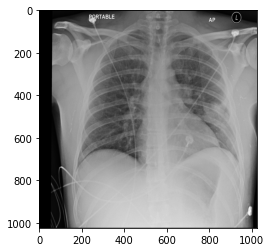

In [ ]:
print("\nAvailable meta data:")
print('-'*20 + "\n")
display(ds_list[24056])

print("\n\nActual image:")
print('-'*13 + "\n")
plt.imshow(ds_list[24056].pixel_array, cmap=plt.cm.gray)
plt.show()

In [ ]:
ds_class_info=pd.read_csv('/content/drive/MyDrive/capstone_dataset/stage_2_detailed_class_info.csv')
ds_train_labels=pd.read_csv('/content/drive/MyDrive/capstone_dataset/stage_2_train_labels.csv')

In [ ]:
#Training Dataset Labels
ds_train_labels.sample(5)

,patientId,x,y,width,height,Target
18531,ae9e413f-ddf3-4fc2-abab-391d69042472,NaN,NaN,NaN,NaN,0
4020,3c2e061f-ad8f-497b-a97f-196d2606ffeb,NaN,NaN,NaN,NaN,0
11392,767b308a-6b69-4290-951f-fd9d1f2a12d6,NaN,NaN,NaN,NaN,0
24151,d926a5e6-012c-4a22-b961-4e2e547f3fca,NaN,NaN,NaN,NaN,0
12571,7fdfc8f8-9505-4390-a520-e948c22aa4d7,NaN,NaN,NaN,NaN,0


In [ ]:
ds_class_info.sample(5)

,patientId,class
4280,3ddd8bc8-e9a2-42f2-b6fc-ef95c5a11d5c,Lung Opacity
11285,759cd727-9e85-43da-b6f0-528818a3f8e1,No Lung Opacity / Not Normal
27452,f3d18e27-278c-439c-bab4-3073cae12b95,No Lung Opacity / Not Normal
22205,c8f6693a-36a2-444c-ad76-6613c41e87ea,Normal
8948,6397c3c5-5c19-421d-ad79-feb94eab5f51,No Lung Opacity / Not Normal


In [ ]:
ds_class_info['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [ ]:
ds_train_labels['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [ ]:
ds_class_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
ds_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


**Only pnemoic class(1) has bounding box values which is 9555**

In [ ]:
ds_list[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.2141.1517874294.835818
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2141.1517874294.835818
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

**Step 2: Map training and testing images to its classes.**

In [ ]:
ds_train_labels_merged = pd.concat([ds_train_labels,ds_class_info.drop(columns=['patientId'])], axis=1)

In [ ]:
ds_train_labels_merged.sample(10)

,patientId,x,y,width,height,Target,class
5950,4b048bdc-0a0a-43ed-aa0d-5971e433874b,637.0,276.0,188.0,282.0,1,Lung Opacity
1485,165bc884-61e3-4fd8-a799-643a8626c7e5,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
12620,80417722-2a5f-4f1f-b11a-31b66619d56b,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3092,361b08cc-bd11-4267-b7d7-7001003db730,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
13370,869facf4-a6d0-452b-b001-c7ca04524955,NaN,NaN,NaN,NaN,0,Normal
27515,f455013b-884e-4f9f-b603-86b137c2b845,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
16881,a2948b66-6ca1-44aa-a8e7-d1943495e95c,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
13889,8aa93e86-e189-4412-ba91-725813f54b56,257.0,338.0,228.0,607.0,1,Lung Opacity
26008,e85ccc63-3449-4bb7-bd0f-2b1798460512,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2234,2d09d0bb-a4fb-4a50-99c4-496ad756533e,199.0,663.0,188.0,70.0,1,Lung Opacity


In [ ]:
ds_train_labels_merged.shape

(30227, 7)

In [ ]:
# null values in x, y, width, height indicates that there is no pneumonia. Replacing null with 0
ds_train_labels_merged.fillna(0, inplace=True)
ds_train_labels_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


**Step 3**: Map training and testing images to its annotations.

In [ ]:
# We need to create a merged data set with all the parameters in one place.
parameters = ['Modality', 'Age', 'Gender', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

#get file list from folder
image_train_path = os.listdir('/content/stage_2_train_images')
image_test_path = os.listdir('/content/stage_2_test_images')

if(os.path.isfile('/content/train_labels_merged_metadata.csv')):
    ds_train_labels_merged = pd.read_csv('/content/train_labels_merged_metadata.csv')
    ds_train_labels_merged.drop([ds_train_labels_merged.columns[0]], axis=1, inplace=True)
else:
    for var in parameters:
          ds_train_labels_merged[var] = None
    #iterate on files and append metadata
    for i,filename in enumerate(image_train_path):
          dcm_data = pydicom.read_file('/content/stage_2_train_images/'+filename)
          idx = (ds_train_labels_merged['patientId']==dcm_data.PatientID)
          ds_train_labels_merged.loc[idx,'Modality'] = dcm_data.Modality
          ds_train_labels_merged.loc[idx,'Age'] = pd.to_numeric(dcm_data.PatientAge)
          ds_train_labels_merged.loc[idx,'Gender'] = dcm_data.PatientSex
          ds_train_labels_merged.loc[idx,'BodyPartExamined'] = dcm_data.BodyPartExamined
          ds_train_labels_merged.loc[idx,'ViewPosition'] = dcm_data.ViewPosition
          ds_train_labels_merged.loc[idx,'ConversionType'] = dcm_data.ConversionType
          ds_train_labels_merged.loc[idx,'Rows'] = dcm_data.Rows
          ds_train_labels_merged.loc[idx,'Columns'] = dcm_data.Columns  
          ds_train_labels_merged.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",dcm_data.PixelSpacing[0]) 
    #save to a file for future
    ds_train_labels_merged.to_csv('/content/train_labels_merged_metadata.csv')

ds_train_labels_merged['xc'] = ds_train_labels_merged['x'] + ds_train_labels_merged['width'] / 2
ds_train_labels_merged['yc'] = ds_train_labels_merged['y'] + ds_train_labels_merged['height'] / 2

ds_train_labels_merged.head()

,patientId,x,y,width,height,Target,class,Modality,Age,Gender,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing,xc,yc
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,51,F,CHEST,PA,WSD,1024,1024,0.143,0.0,0.0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,48,F,CHEST,PA,WSD,1024,1024,0.194,0.0,0.0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,CR,19,M,CHEST,AP,WSD,1024,1024,0.168,0.0,0.0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,CR,28,M,CHEST,PA,WSD,1024,1024,0.143,0.0,0.0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,CR,32,F,CHEST,AP,WSD,1024,1024,0.139,370.5,341.5


In [ ]:

#--> mss/ fss: male/ female senior citizen; mped/ fped: male/female pediatric patient; madult/fadult: male/ female

from keras.engine.data_adapter import GeneratorDataAdapter
mss,mn,mped,mpreteen,mteen,madult=0,0,0,0,0,0
fss,fn,fped,fpreteen,fteen,fadult=0,0,0,0,0,0

x=ds_train_labels_merged['Age']
y=ds_train_labels_merged['Gender']

for i in range(len(ds_train_labels_merged['Gender'])):
    if y[i]=='M':
        #for j in range(len(ds_list['Age'])):
        if x[i]>18:
            madult+=1
        if x[i]<=18 :
            mteen+=1
        if x[i]<=10 :
            mped+=1
        if x[i]>80 :
            mss+=1
        
    if y[i]=='F':
        #for j in range(len(ds_train_labels_merged['Age'])):
        if x[i]>18:
            fadult+=1
        elif x[i]<=18 :
            fteen+=1
        elif x[i]<=10 :
            fped+=1
        elif x[i]>60 :
            fss+=1
        

display("Male", "adult",madult, "teen",mteen,"ped", mped, "mss", mss)
display("FeMale", fadult, "teen",fteen,"ped",fped, "fss", fss)

'Male'

'adult'

16174

'teen'

1042

'ped'

334

'mss'

148

'FeMale'

12355

'teen'

656

'ped'

0

'fss'

0

**Step 4:** Preprocessing and Visualisation of different classes [4 Point]

In [ ]:
bounding_box_count = {}
for patient in ds_train_labels.patientId:
    delme = ds_train_labels[ds_train_labels['patientId'] == patient]
    for index, row in delme.iterrows():
        stri = " ".join([str(row['x']),
                    str(row['y']), 
                    str(row['width']), 
                    str(row['height'])])
        if patient in bounding_box_count:
            bounding_box_count[patient].add(stri)
        else:
            bounding_box_count[patient] = set()
            bounding_box_count[patient].add(stri)


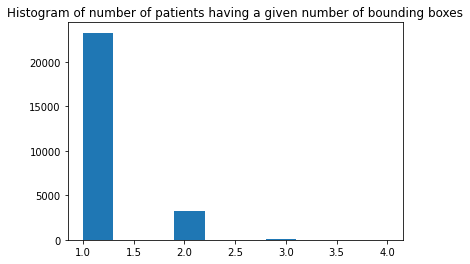

In [ ]:
bbcnt = [len(list(bounding_box_count[k])) for k in bounding_box_count]
plt.hist(bbcnt)
plt.title("Histogram of number of patients having a given number of bounding boxes")
plt.show()

In [ ]:
def preproc(fndf, tarvar):
    dupli = fndf.duplicated()
    non_duplicated_data = fndf[~dupli]
    duplicated_data = fndf[dupli]

    # checking for duplicates
    print("\nTotal Patients:", fndf['patientId'].count())
    print("Unique Patients:", fndf['patientId'].nunique())
    
    # Value counts:
    print("\n\nValue Counts in duplicated data:")
    print(fndf[tarvar].value_counts())
    ax = sns.countplot(x = tarvar, data = fndf)
    for p, label in zip(ax.patches, fndf[tarvar].value_counts().index):
        ht_label = str(round(float(p.get_height())/len(fndf)*100, 2))
        ax.annotate(ht_label + "%", (p.get_x()+0.375, p.get_height()+10))
    plt.show()

    print("\n\nValue Counts in non-duplicated data:")
    print(non_duplicated_data[tarvar].value_counts())
    ax = sns.countplot(x = tarvar, data = non_duplicated_data)
    for p, label in zip(ax.patches, non_duplicated_data[tarvar].value_counts().index):
        ht_label = str(round(float(p.get_height())/len(non_duplicated_data)*100, 2))
        ax.annotate(ht_label + "%", (p.get_x()+0.375, p.get_height()+10))
    plt.show()

    print("\n\nINFO:")
    print(fndf.info())

    print("\n\ndescribe:")
    print(fndf.describe()) 



Total Patients: 30227
Unique Patients: 26684


Value Counts in duplicated data:
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


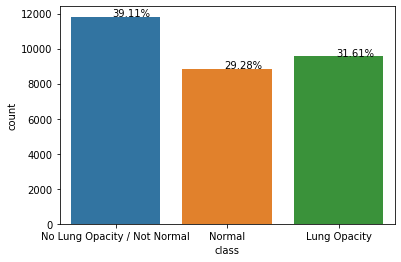



Value Counts in non-duplicated data:
No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64


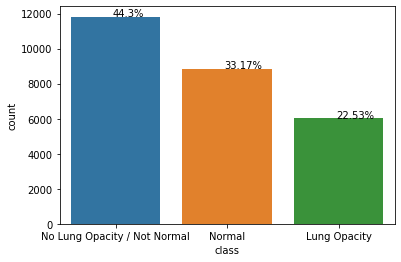



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB
None


describe:
                                   patientId                         class
count                                  30227                         30227
unique                                 26684                             3
top     3239951b-6211-4290-b237-3d9ad17176db  No Lung Opacity / Not Normal
freq                                       4                         11821


In [ ]:
preproc(ds_class_info,'class')

#### Observations:
1. There are 26,684 Images in train set
2. There are 30227 records in Class Information, and Train Labels set
3. There are 9555 records with "Lung Opacity" and correspondingly
4. There are 6021 patients with single Lung Opacity instance
5. There are 3543 patients with two Lung Opacity instance


In [ ]:
#--> printed for clarity::
display("Train Set",ds_list[0].pixel_array.shape)
display("Test Set",ds_list_test[0].pixel_array.shape)
display("Train Set", ds_list[0].pixel_array)
display("Test Set",ds_list_test[0].pixel_array)


'Train Set'

(1024, 1024)

'Test Set'

(1024, 1024)

'Train Set'

array([[253, 250, 248, ..., 250, 255, 169],
       [245, 243, 243, ..., 249, 255, 167],
       [243, 243, 242, ..., 249, 255, 167],
       ...,
       [ 15,  15,  15, ...,  32,  31,  15],
       [ 15,  15,  15, ...,  32,  31,  15],
       [ 15,  15,  15, ...,  31,  31,  15]], dtype=uint8)

'Test Set'

array([[ 3,  2,  2, ...,  2,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 3,  3,  3, ...,  3,  3,  3],
       ...,
       [47, 83, 80, ..., 32, 33, 20],
       [53, 85, 79, ..., 32, 33, 21],
       [22, 49, 39, ..., 18, 20,  8]], dtype=uint8)

In [ ]:
male=ds_train_labels_merged[ds_train_labels_merged['Gender']=='M']
female=ds_train_labels_merged[ds_train_labels_merged['Gender']=='F']

Gender and Classwise Age Distribution


[Text(0, 0.5, 'Female')]

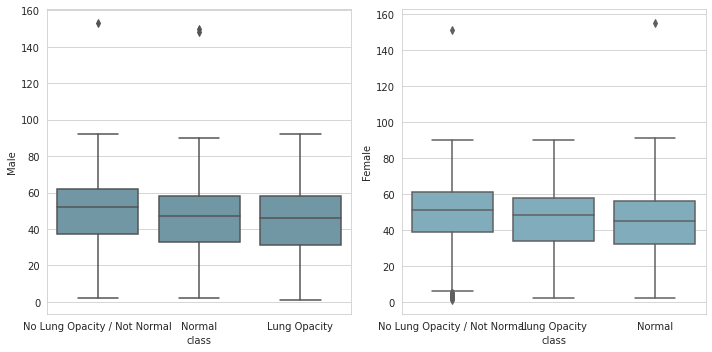

In [ ]:
print("Gender and Classwise Age Distribution")
sns.set_style("whitegrid")
c1='No Lung Opacity / Not Normal'
c2='Lung Opacity'
c3='Normal'

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2, ) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)

mc1=sns.boxplot(y=male['Age'], x=male['class'], data=male.sort_values("class"), ax=ax1,color='#689aad')
mc1.set(ylabel='Male')

mc1=sns.boxplot(y=female['Age'], x=female['class'], data=female.sort_values("class"), ax=ax2,color='#77b0c6')
mc1.set(ylabel='Female')


In [ ]:
from matplotlib.patches import Rectangle

def plot_opa_dist(data,color_point, color_window,text):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    plt.title("Lung Opacity (Centre) rectangles\n{}".format(text))
    data.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color=color_point)
    for i, crt_sample in data.iterrows():
        ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
            width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color=color_window))
    plt.show()

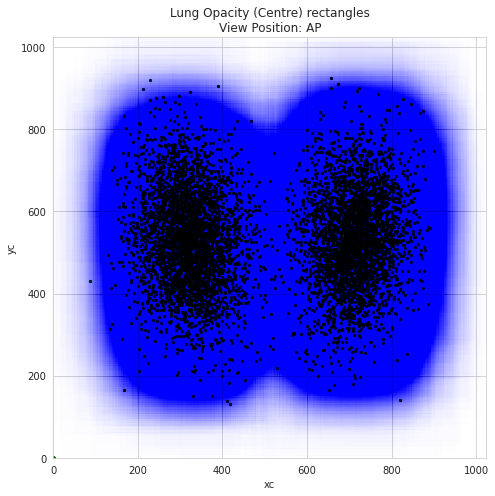

In [ ]:
position_par = (ds_train_labels_merged['ViewPosition']=='AP') 

plot_opa_dist(ds_train_labels_merged[ position_par ],'green', 'blue', 'View Position: AP')

The above plot shows Lung Opacity area (Area calculated from bounding box dimensions) over X Rays taken in "Anterior Posterior" position. 

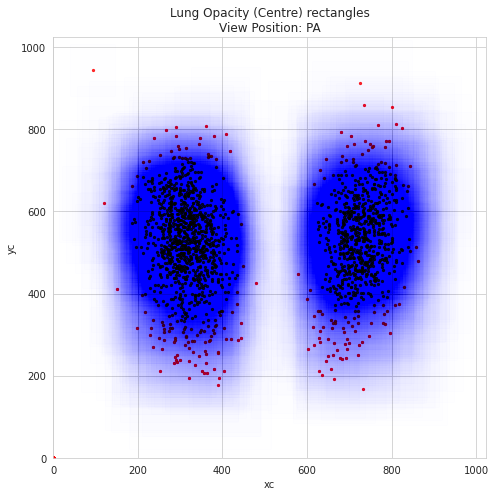

In [ ]:
position_par = (ds_train_labels_merged['ViewPosition']=='PA') 

plot_opa_dist(ds_train_labels_merged[ position_par ],'red', 'blue', 'View Position: PA')

The above plot shows Lung Opacity area over X Rays taken in "Posterior-Anterior (PA) " position.  

**Step 5: Display images with bounding box. [ 5 points ]**

In [ ]:
def plot_img_bbox(img, df, name, extra_names=""):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    a.imshow(img, cmap = 'gray')
    boxes_df = df[df['patientId']==name]

    for index, row in boxes_df.iterrows():
        x, y, width, height  = row['x'], row['y'], row['width'], row['height']
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.title(name +  " "  + extra_names)
    plt.show()

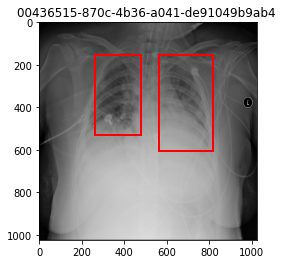

In [ ]:
lung_opacity_patient = "00436515-870c-4b36-a041-de91049b9ab4"
patient_index = ds_train_names.index(lung_opacity_patient + ".dcm")
img = ds_list[patient_index].pixel_array
plot_img_bbox(img, ds_train_labels_merged, lung_opacity_patient)

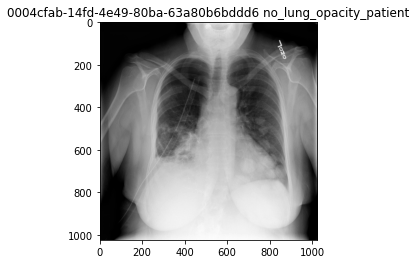

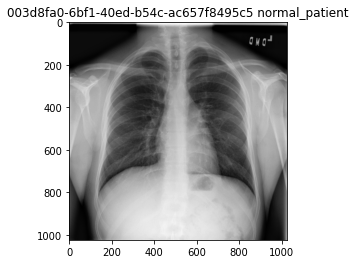

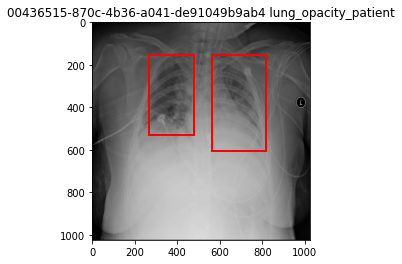

In [ ]:
no_lung_opacity_patient = "0004cfab-14fd-4e49-80ba-63a80b6bddd6"
patient_index = ds_train_names.index(no_lung_opacity_patient + ".dcm")
img = ds_list[patient_index].pixel_array
plot_img_bbox(img, ds_train_labels_merged, no_lung_opacity_patient, "no_lung_opacity_patient")

normal_patient = "003d8fa0-6bf1-40ed-b54c-ac657f8495c5"
patient_index = ds_train_names.index(normal_patient + ".dcm")
img = ds_list[patient_index].pixel_array
plot_img_bbox(img, ds_train_labels_merged, normal_patient, "normal_patient")

lung_opacity_patient = "00436515-870c-4b36-a041-de91049b9ab4"
patient_index = ds_train_names.index(lung_opacity_patient + ".dcm")
img = ds_list[patient_index].pixel_array
plot_img_bbox(img, ds_train_labels_merged, lung_opacity_patient, "lung_opacity_patient")



**Step 6: Design, train and test basic CNN models for classification.**

Split the data into train and validation set

In [ ]:
# Use part of the data for training earlier and then run for 100% of the data
import random
from skimage.transform import resize
folder = 'stage_2_train_images'
filenames = os.listdir(folder)
percentage_data_used = 50
file_count = int(len(filenames)*percentage_data_used/100)
print("Total files available:",file_count)


Total files available: 13342


In [ ]:
random.shuffle(filenames)

# split into train and validation filenames
n_valid_samples = int(file_count * 0.3)

train_filenames = filenames[n_valid_samples:file_count]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

image_dimension = 128
print('Image Dimension to use:',image_dimension)
print('sample file:',filenames[179])

n train samples 9340
n valid samples 4002
Image Dimension to use: 128
sample file: 77312e52-25fe-4a0d-83a1-5c04789e5ac8.dcm


In [ ]:
# Check dist of selected files based on the csv that was provided. 
# Did not try stratified sampling since the distribution is not impacted much.
def check_distribution(dataframe_to_check):
  filename_check = pd.DataFrame(columns=['patientId','class'])
  #get filename 
  for filename in dataframe_to_check:
    filename_check = filename_check.append(ds_train_labels_merged[ds_train_labels_merged['patientId'] == filename.split('.')[0]])
    
  print('Rows',len(filename_check))
  print('unique',len(filename_check['patientId'].unique()))
  print(filename_check['class'].value_counts(normalize = True))

check_distribution(train_filenames)
check_distribution(valid_filenames)

Rows 10537
unique 9340
No Lung Opacity / Not Normal    0.397457
Lung Opacity                    0.307962
Normal                          0.294581
Name: class, dtype: float64
Rows 4547
unique 4002
No Lung Opacity / Not Normal    0.380691
Lung Opacity                    0.322190
Normal                          0.297119
Name: class, dtype: float64


In [ ]:
check_distribution(filenames)
# Overall Distribution is very similar to the distribution in train and validation data set.

Rows 30227
unique 26684
No Lung Opacity / Not Normal    0.391074
Lung Opacity                    0.316108
Normal                          0.292818
Name: class, dtype: float64


In [ ]:
# identifying if there are any files beside dcm in the folder
for name in filenames:
  le = len(name)
  if(name[le-3:le] != 'dcm'):
    print(name)

In [ ]:
! ls /content/drive/MyDrive

 CapstoneCVPnemonia
 capstone_dataset
 capstone_datasetlogs_cnn_segment.csv
 capstone_datasetpneumonia_model.h5
 capstone_datasetpneumonia_model_history.csv
'Colab Notebooks'


Create a dictionary of pneumonia locations in one place.

In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/capstone_dataset"
SAVE_PATH = "/content/drive/MyDrive/capstone_dataset"
TRAIN_PATH = "/content/stage_2_train_images"

In [ ]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join(PROJECT_PATH,'stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

**Generator class**

In [ ]:
import keras

# The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.
# Generator class to handle:
# Image load from folder during train and predict modes, shuffle on epoc end, 
# resize loaded images, augment if needed, add trailing channel dimension
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=image_dimension, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    # Loads the file from folder, resizes and augments the data with horizontal flip    
    def __load__(self, filename):
        # load dicom file as numpy array
        #print('reading file:', filename)
        img = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array

        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect')
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    # Loads images during prediction cycles
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        # print('reading file:', filename)
        img = pydicom.dcmread(os.path.join(self.folder, filename), force=True).pixel_array
        
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    # Generator must implement this getter function    
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks

    # Shuffle data before start of next epoc    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [ ]:
def set_and_train_model(batch_size, train_filenames, valid_filenames, epochs):

    print('STARTING TRAINING\n\n')
    print(f"SETTINGS: \nbatch_size: {batch_size}\ntrain_filenames:{len(train_filenames)}")
    print(f"valid_filenames:{len(valid_filenames)}\nepochs:{epochs}\n\n")

    # create 1 downsample layer, each containing 4 layers in it
    def create_downsample(channels, inputs):
        x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
        x = keras.layers.MaxPool2D(2)(x)
        return x

    # creates 1 residual layer, each containing 6 layers in it.
    def create_resblock(channels, inputs):
        x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
        return keras.layers.add([x, inputs])

    # Model creator
    # Depth = number of layers in the model
    def create_network(input_size, channels, n_blocks=2, depth=4):
        # input layers - 2 layer
        inputs = keras.Input(shape=(input_size, input_size, 1))
        x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
        # residual blocks (4*4 downsample + 4*2*6 resblock = 64 layers)
        for d in range(depth):
            channels = channels * 2
            x = create_downsample(channels, x)
            for b in range(n_blocks):
                x = create_resblock(channels, x)
        # output - 4 layers
        x = keras.layers.BatchNormalization(momentum=0.9)(x)
        x = keras.layers.LeakyReLU(0)(x)
        x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
        outputs = keras.layers.UpSampling2D(2**depth)(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        return model


    # define iou or jaccard loss function
    def iou_loss(y_true, y_pred):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true * y_pred)
        score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
        return 1 - score

    # combine bce loss and iou loss
    def iou_bce_loss(y_true, y_pred):
        return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

    # mean iou as a metric
    def mean_iou(y_true, y_pred):
        y_pred = tf.round(y_pred)
        intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
        smooth = tf.ones(tf.shape(intersect))
        return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

    # create network and compiler
    model = create_network(input_size=image_dimension, channels=32, n_blocks=2, depth=2)
    model.compile(optimizer='adam',
                  loss=iou_bce_loss,
                  metrics=['accuracy', mean_iou])


    print("\nMODEL SUMMARY:\n")
    print(model.summary())

    # cosine learning rate annealing
    # changes learning rate based on the number of epocs passed
    def cosine_annealing(x):
        lr = 0.001
        epochs = 25
        return lr* (np.cos(np.pi*x/epochs)+1.) /2
    learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

    # keeps logging the epoc output simultaneously while training
    csv_logger = tf.keras.callbacks.CSVLogger(SAVE_PATH + 'logs_cnn_segment.csv', append = True)

    # Creating checkpoint of the best model to avoid save errors later on.
    # Saves training time once the best model is achieved.
    cp = tf.keras.callbacks.ModelCheckpoint(filepath = SAVE_PATH + 'model_checkpoint.h5', verbose = 1, save_best_only = True)

    # Keep monitoring val_loss to see if there is any improvement. 
    # Mostly the model kept loss in a range so keeping patience as 4 to avoid bloating training time. 
    # Any improvement of 0.5% in val_loss would get captured
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=4, restore_best_weights=True, verbose=1, mode='auto')



    # create train and validation generators
    train_gen = generator(TRAIN_PATH, train_filenames, pneumonia_locations, batch_size=batch_size, image_size=image_dimension, shuffle=False, augment=False, predict=False)
    valid_gen = generator(TRAIN_PATH, valid_filenames, pneumonia_locations, batch_size=batch_size, image_size=image_dimension, shuffle=False, predict=False)
     
    print("\n\nMODEL TRAINING:\n")
    history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate,csv_logger,early_stopping], 
                                  epochs=epochs, workers=4, use_multiprocessing=True)

    # Save Model and history
    training_mode = True
    if(training_mode):
      export_file_path = SAVE_PATH+'pneumonia_model.h5'

      # Save the model
      model.save(export_file_path)
      print('model saved\n')

      # Save history file
      print(history.history.keys())
      # convert the history.history dict to a pandas DataFrame:     
      hist_df = pd.DataFrame(history.history) 

      # or save to csv: 
      hist_csv_file = SAVE_PATH+'pneumonia_model_history.csv'
      with open(hist_csv_file, mode='w') as f:
          hist_df.to_csv(f)
      print('history saved\n')

      
    else:
      model.load_weights(SAVE_PATH+'pneumonia_model.h5')
      history = pd.read_csv(SAVE_PATH+'pneumonia_model_history.csv')
      history


    ## Accuracy and Loss plots

    print("\n\n PLOTTING TRAINING RESULTS \n")

    accuracy      = history.history['accuracy']
    val_accuracy  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs   = range(len(accuracy)) # Get number of epochs

    plt.plot  (epochs, accuracy, label = 'training accuracy')
    plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
    plt.title ('Training and validation accuracy')
    plt.legend(loc = 'lower right')
    plt.figure()

    plt.plot  (epochs, loss, label = 'training loss')
    plt.plot  (epochs, val_loss, label = 'validation loss')
    plt.legend(loc = 'upper right')
    plt.title ('Training and validation loss')

    plt.show()

    # load and shuffle filenames
    folder = '/content/stage_2_test_images'
    test_filenames = os.listdir(folder)[:50]
    print("\n\n PREDICTING TEST SET:\n")
    print('n test samples:', len(test_filenames))

    model.load_weights(SAVE_PATH+'pneumonia_model.h5')

    # fn = list(set(ds_train_labels_merged[ds_train_labels_merged['class'] == 'Lung Opacity']['patientId']))[0:100]
    # folder = '/content/stage_2_train_images'
    # test_filenames = [i + ".dcm" for i in fn]
    # create test generator with predict flag set to True
    test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=128, shuffle=False, predict=True)

    print("\n\n SUBMISSION DICT : ")
    # create submission dictionary
    submission_dict = {}
    # loop through testset
    for imgs, filenames in test_gen:
        # predict batch of images
        preds = model.predict(imgs)
        # loop through batch
        for pred, filename in zip(preds, filenames):
            # resize predicted mask
            pred = resize(pred, (1024, 1024), mode='reflect')
            # threshold predicted mask
            comp = pred[:, :, 0] > 0.5
            # apply connected components
            comp = measure.label(comp)
            # apply bounding boxes
            predictionString = ''
            for region in measure.regionprops(comp):
                # retrieve x, y, height and width
                y, x, y2, x2 = region.bbox
                height = y2 - y
                width = x2 - x
                # proxy for confidence score
                conf = np.mean(pred[y:y+height, x:x+width])
                # add to predictionString
                predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
            # add filename and predictionString to dictionary
            filename = filename.split('.')[0]
            submission_dict[filename] = predictionString
        # stop if we've got them all
        if len(submission_dict) >= len(test_filenames):
            break

    return submission_dict


STARTING TRAINING


SETTINGS: 
batch_size: 100
train_filenames:800
valid_filenames:100
epochs:5



MODEL SUMMARY:

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_84 (Conv2D)             (None, 128, 128, 32  288         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_77 (BatchN  (None, 128, 128, 32  128        ['conv2d_84

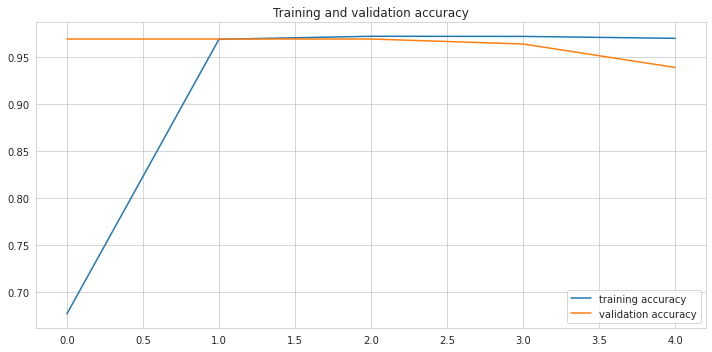

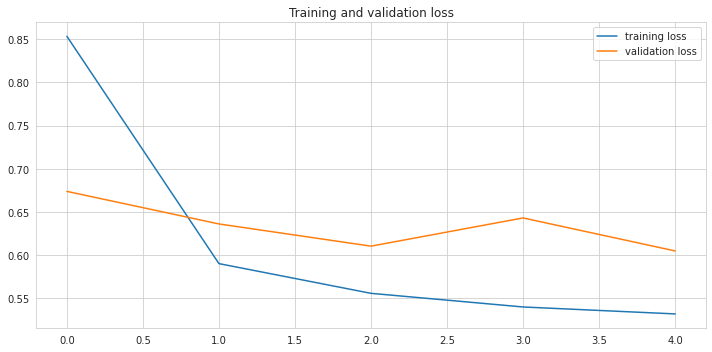



 PREDICTING TEST SET:

n test samples: 50


 SUBMISSION DICT : 
1/1 [==============================] - 0s 21ms/step


{'057a7499-4836-44ef-9490-56b002cd63c2': '0.5356421 799 98 63 30 0.4569728 353 481 319 316 ',
 '1c0af194-eab2-4f27-9e00-03d7b9575ff6': '0.50810844 292 132 25 24 ',
 '2dd86bb9-61ef-4efd-843b-da1b58ac5092': '0.51631474 159 477 222 160 0.46311727 578 514 187 160 ',
 '1dfade34-d928-490c-971c-ffc485f686ab': '0.4523751 67 97 189 94 0.47330725 676 98 185 63 0.5042371 545 162 162 221 0.5285575 189 226 161 219 ',
 '1e73864f-f136-46ac-b75e-6153a332e780': '0.52144015 285 158 65 35 0.50009376 606 416 133 226 0.54337037 225 418 160 194 ',
 '2f27d72f-4e93-482c-b52e-d15db6e66d9a': '',
 '2cbe226e-abd7-4c75-94ab-a4c048c253d2': '0.523316 674 288 94 129 0.5002833 740 484 24 24 0.5092775 324 640 60 30 ',
 '23efc2ad-684a-4f0b-910c-645a58bcbd7e': '0.4615949 674 544 122 222 0.52808905 225 643 190 96 0.515895 670 770 33 32 ',
 '1d90bab0-ba72-4126-9c2e-11c80a9b2e21': '0.553299 192 62 95 34 0.5404697 675 65 91 32 0.51457053 671 324 68 221 0.5056084 289 384 28 60 0.5034423 772 707 25 26 0.5134059 800 737 29 28 '

In [ ]:
set_and_train_model(batch_size=100, train_filenames=train_filenames[:800], valid_filenames=valid_filenames[:100], epochs=5)


**With all files in current sampled training set:**

Listing out:
1. training results
2. Plotting training results
3. Predicting test data
4. Visualising a few validation results


STARTING TRAINING


SETTINGS: 
batch_size: 50
train_filenames:9340
valid_filenames:4002
epochs:5



MODEL SUMMARY:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][

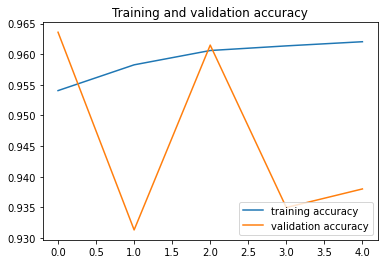

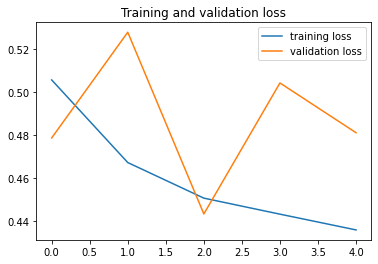



 PREDICTING TEST SET:

n test samples: 50


 SUBMISSION DICT : 
1/1 [==============================] - 0s 20ms/step


{'057a7499-4836-44ef-9490-56b002cd63c2': '0.8393514 157 128 675 706 ',
 '1c0af194-eab2-4f27-9e00-03d7b9575ff6': '0.6118377 99 253 250 449 0.73874444 445 321 256 483 ',
 '2dd86bb9-61ef-4efd-843b-da1b58ac5092': '0.6380038 129 163 735 637 ',
 '1dfade34-d928-490c-971c-ffc485f686ab': '0.70166343 572 286 256 513 0.6448626 126 317 352 512 0.5968466 448 545 100 63 ',
 '1e73864f-f136-46ac-b75e-6153a332e780': '0.59596425 285 638 70 35 0.5552616 642 670 123 99 ',
 '2f27d72f-4e93-482c-b52e-d15db6e66d9a': '0.5696435 607 415 66 132 0.5231025 195 547 26 26 ',
 '2cbe226e-abd7-4c75-94ab-a4c048c253d2': '0.5016957 638 354 159 315 0.55728734 540 672 164 159 ',
 '23efc2ad-684a-4f0b-910c-645a58bcbd7e': '',
 '1d90bab0-ba72-4126-9c2e-11c80a9b2e21': '0.56931376 284 609 70 128 0.5733374 163 672 97 65 ',
 '2b635aad-66e7-49da-808e-14f59dc98fe0': '0.7623817 511 225 352 608 ',
 '0ea77882-9a44-463b-9141-b8a714c83dd1': '',
 '231a1bc7-7262-4330-ab24-ad777a4eb452': '',
 '1fb4d7b3-b133-4c57-8657-f3176e0db110': '0.577847

In [ ]:
set_and_train_model(batch_size=50, train_filenames=train_filenames, valid_filenames=valid_filenames, epochs=5)

**Observations from the training**


*  The Loss plot and the accuracy plot show that with the larger dataset, we might need a large batch size as well to have consistent improvement and reach a local minima.We currently can't do that because of shortage of RAM we bought in googlecolab.
*  The submission sample is looking good however - we are able to predict bounding boxes in some test samples. 
* There are a few samples that have 0, 1 or 2 bounding boxes. 
* There are a few samples that have 3 bounding boxes too. The accuracy of this will be revisited in milestone 2. 



In [ ]:
# create 1 downsample layer, each containing 4 layers in it
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

# creates 1 residual layer, each containing 6 layers in it.
def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

# Model creator
# Depth = number of layers in the model
def create_network(input_size, channels, n_blocks=2, depth=4):
    # input layers - 2 layer
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks (4*4 downsample + 4*2*6 resblock = 64 layers)
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output - 4 layers
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=image_dimension, channels=32, n_blocks=2, depth=2)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

1/1 [==============================] - 0s 182ms/step


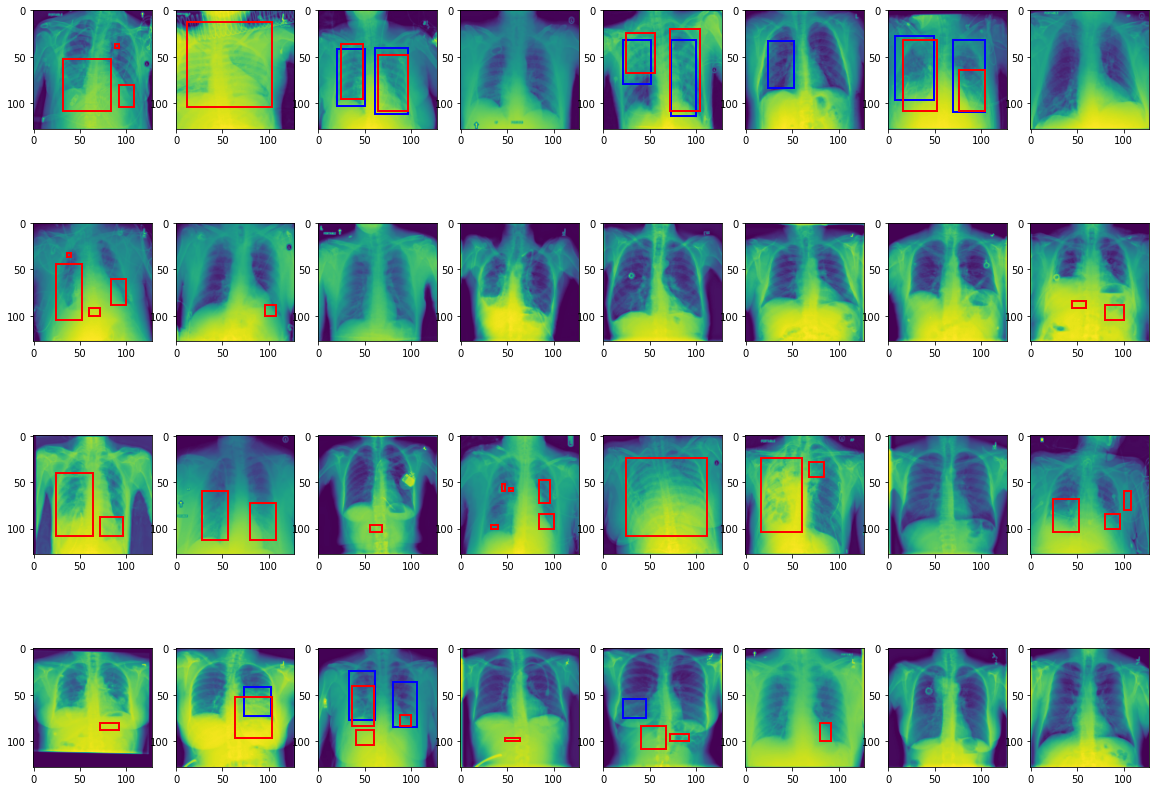

In [ ]:
# Red is predicted mask, Blue is actual Mask
model.load_weights(SAVE_PATH+'pneumonia_model.h5')

valid_gen = generator(TRAIN_PATH, valid_filenames, pneumonia_locations, batch_size=32, image_size=128, shuffle=False, predict=False)

for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))

    # Flatten the array
    axarr = axarr.ravel()
    axidx = 0

    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
        if axidx == 32:
          break
    plt.show()
    # only plot one batch
    break

# There was considerable IOU for the images where prediction was correct. 

**Visualising some of the validation set**


*  The Red is predicted mask, Blue is actual Mask.
*  There are patients for whom the predicted mask and actual mask are pretty overlapping. 
* There are a few false positives observed as well.
* These are certain areas we want to address as part of milestone 2
